## **Traditional Models**

### Importing Necessary Libraries

In [ ]:
# ------------------------------------------
# Part 1: EDA + Preprocessing (Corrected)
# ------------------------------------------

# Basic Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Scikit-Learn Essentials
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

# Deep Learning Essentials
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set Plot Style
sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ------------------------------------------
# 1. Load Data
# ------------------------------------------
train_val_df = pd.read_excel('/content/drive/MyDrive/INFO617/project/INFO 617 Group Project Train Val.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/INFO617/project/INFO 617_Group Project Test Set.xlsx')

print("Train Shape:", train_val_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (4030, 2)
Test Shape: (1187, 2)


In [ ]:
# ------------------------------------------
# 2. Quick Glance at Data
# ------------------------------------------
print(train_val_df.head())


                                            Sentence      Label
0                                             Hello,      GREET
1   the rubella virus IgM was detected at around ...     REPEAT
2  which has a 50% chance of causing intrauterine...  DIAGNOISE
3  Intrauterine infection can lead to risks such ...    EXPLAIN
4  Please note that these risks may or may not oc...    EXPLAIN


### Data Cleaning and Preprocessing

In [ ]:
# ------------------------------------------
# 3. Check for Missing Values
# ------------------------------------------
print(train_val_df.isnull().sum())


Sentence    0
Label       0
dtype: int64


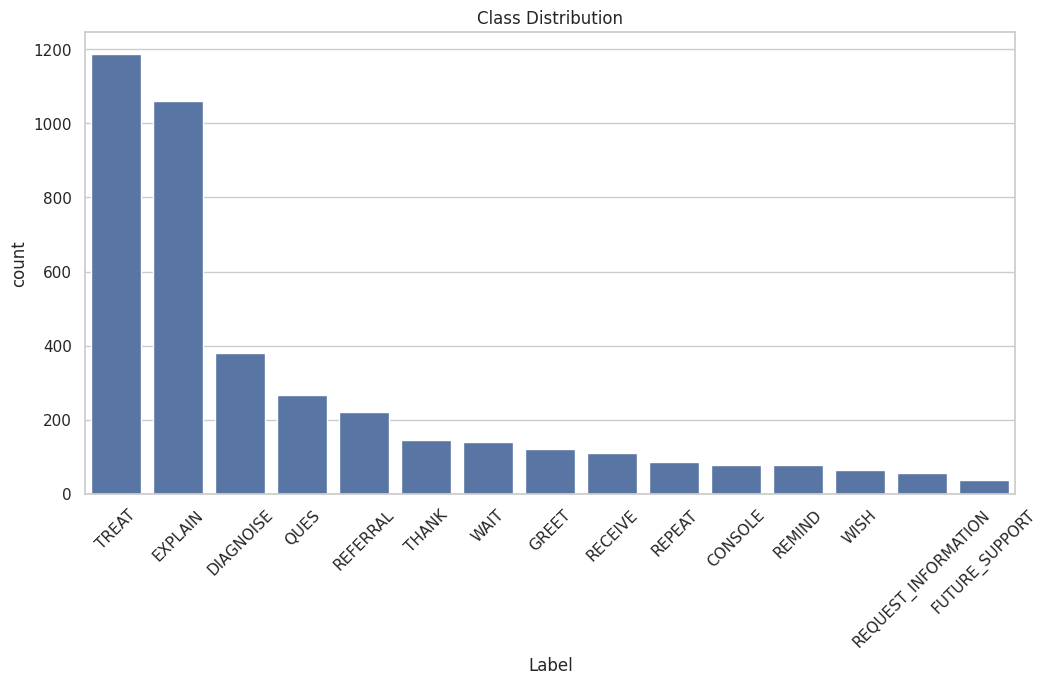

Label
TREAT                  29.48
EXPLAIN                26.33
DIAGNOISE               9.45
QUES                    6.63
REFERRAL                5.51
THANK                   3.60
WAIT                    3.45
GREET                   2.98
RECEIVE                 2.73
REPEAT                  2.13
CONSOLE                 1.94
REMIND                  1.94
WISH                    1.59
REQUEST_INFORMATION     1.36
FUTURE_SUPPORT          0.89
Name: proportion, dtype: float64


In [ ]:
# ------------------------------------------
# 4. Check Class Distribution
# ------------------------------------------
plt.figure(figsize=(12,6))
sns.countplot(data=train_val_df, x='Label', order=train_val_df['Label'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.show()

# Print percentage distribution
print((train_val_df['Label'].value_counts(normalize=True) * 100).round(2))


In [ ]:
# ------------------------------------------
# 3. Data Cleaning Function
# ------------------------------------------
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_val_df['clean_text'] = train_val_df['Sentence'].apply(clean_text)
test_df['clean_text'] = test_df['Sentence'].apply(clean_text)

### Label Encoding
The sentence labels were encoded into numeric format using LabelEncoder to make them compatible with traditional machine learning classifiers. This step assigned each unique label a distinct integer value, enabling the models to treat classification as a multi-class prediction task.



In [ ]:
# ------------------------------------------
# 4. Encode Labels
# ------------------------------------------
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_val_df['Label'])
class_names = label_encoder.classes_

# For Test Set
y_test_true = label_encoder.transform(test_df['Label'])

### Data Segmentation
The cleaned and label-encoded dataset was split into training and validation sets using an 80/20 stratified split. Stratification ensured that the class distributions were preserved across both sets, which is crucial for fair evaluation of multi-class classification models. This split provided a solid foundation for model training and validation.

In [ ]:
# ------------------------------------------
# 5. Train/Validation Split (80/20)
# ------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(train_val_df['clean_text'], y, test_size=0.2, random_state=42, stratify=y)

print("Training Size:", X_train.shape)
print("Validation Size:", X_val.shape)

Training Size: (3224,)
Validation Size: (806,)


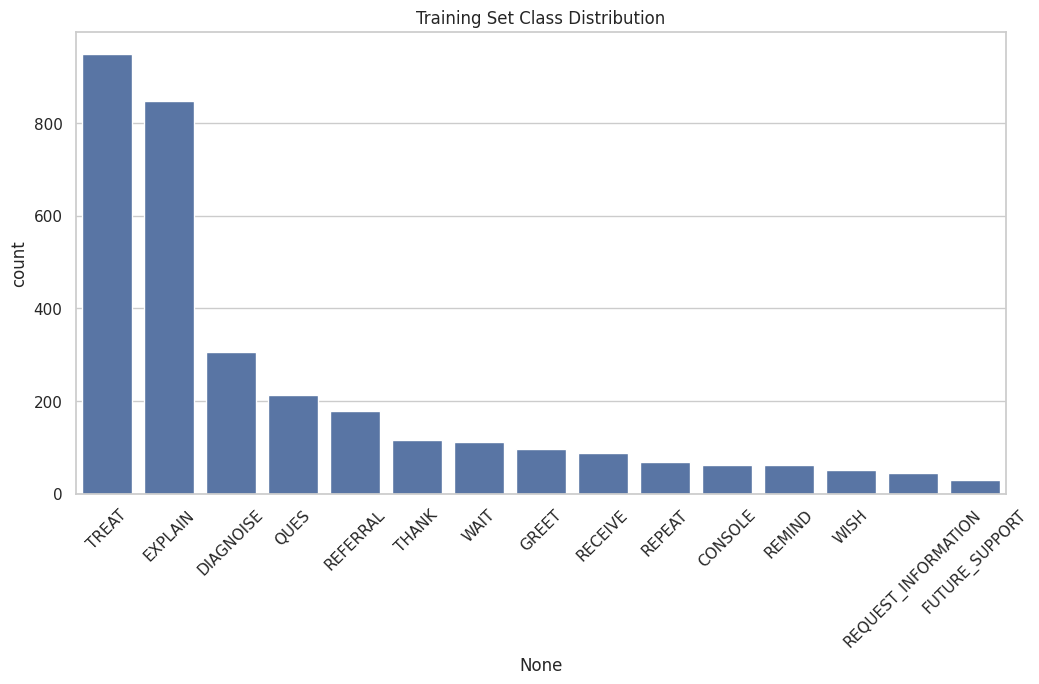

12    29.47
2     26.33
1      9.46
5      6.64
7      5.52
11     3.60
13     3.44
4      2.98
6      2.73
9      2.14
0      1.92
8      1.92
14     1.58
10     1.36
3      0.90
Name: proportion, dtype: float64


In [ ]:
# ------------------------------------------
# 6. Check Class Distribution After Split
# ------------------------------------------
plt.figure(figsize=(12,6))
sns.countplot(x=pd.Series(y_train).map(lambda i: class_names[i]), order=pd.Series(y_train).map(lambda i: class_names[i]).value_counts().index)
plt.xticks(rotation=45)
plt.title('Training Set Class Distribution')
plt.show()

print((pd.Series(y_train).value_counts(normalize=True) * 100).round(2))


After splitting the dataset, the class distribution in the training set was analyzed to verify the effectiveness of stratified sampling. The distribution remained consistent with the original dataset, although some classes like TREAT and EXPLAIN were more frequent compared to minority classes like REQUEST_INFORMATION and FUTURE_SUPPORT. This analysis highlighted the need to monitor class imbalance when evaluating model performance.

### TF-IDF Feature Extraction
Text data was transformed into numerical features using TF-IDF vectorization. Unigrams and bigrams were extracted with a vocabulary size limited to 5000, and common English stopwords were removed. This transformation allowed traditional machine learning models to operate effectively on sparse, high-dimensional representations of the input sentences.

In [ ]:
# ------------------------------------------
# 7. Text Vectorization: TF-IDF (before resampling)
# ------------------------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_text'])

print("TF-IDF Train Shape:", X_train_tfidf.shape)

TF-IDF Train Shape: (3224, 5000)


### Handling Class Imbalance
To address class imbalance after TF-IDF feature extraction, SMOTE (Synthetic Minority Over-sampling Technique) was conditionally applied. SMOTE synthetically generated new examples for minority classes, helping to balance the training data and enabling the models to learn from a more representative sample distribution. If no significant imbalance was detected, the original training set was retained.

In [ ]:
# ------------------------------------------
# 8. Resampling (Handle Class Imbalance if Necessary) - Apply after TF-IDF
# ------------------------------------------
if pd.Series(y_train).min() / pd.Series(y_train).max() < 0.5:
    print("Applying SMOTE for Resampling...")
    smote = SMOTE(random_state=42)
    X_train_tfidf_resample, y_train_resample = smote.fit_resample(X_train_tfidf, y_train)
else:
    print("No significant imbalance detected.")
    X_train_tfidf_resample, y_train_resample = X_train_tfidf, y_train


Applying SMOTE for Resampling...


### ML Models

In [ ]:
# ------------------------------------------
# Part 2: Traditional Machine Learning Models (Expanded)
# ------------------------------------------

In [ ]:
# Model Evaluation Function
def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted'):.4f}")

In [ ]:

def plot_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### Logistic Regression: Training, Hyperparameter Tuning, and Evaluation
Logistic Regression was applied as a baseline traditional model using TF-IDF features. Initially trained with default settings, it achieved a validation accuracy of 66.75%. Hyperparameter tuning was conducted using GridSearchCV to optimize the regularization parameter C. The retrained model with the best parameter (C value) achieved a final validation accuracy of 66.00% and a weighted F1-score of 65.53%. This made Logistic Regression the best-performing traditional machine learning model among those tested.


===== Logistic Regression =====

Logistic Regression (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.71      0.75      0.73        16
          DIAGNOISE       0.46      0.58      0.51        76
            EXPLAIN       0.66      0.57      0.61       212
     FUTURE_SUPPORT       0.67      0.57      0.62         7
              GREET       0.96      0.96      0.96        24
               QUES       0.40      0.42      0.41        53
            RECEIVE       0.95      0.95      0.95        22
           REFERRAL       0.56      0.73      0.63        44
             REMIND       0.92      0.69      0.79        16
             REPEAT       0.12      0.12      0.12        17
REQUEST_INFORMATION       0.30      0.27      0.29        11
              THANK       0.90      0.97      0.93        29
              TREAT       0.77      0.76      0.76       238
               WAIT       0.78      0.89      0.83  

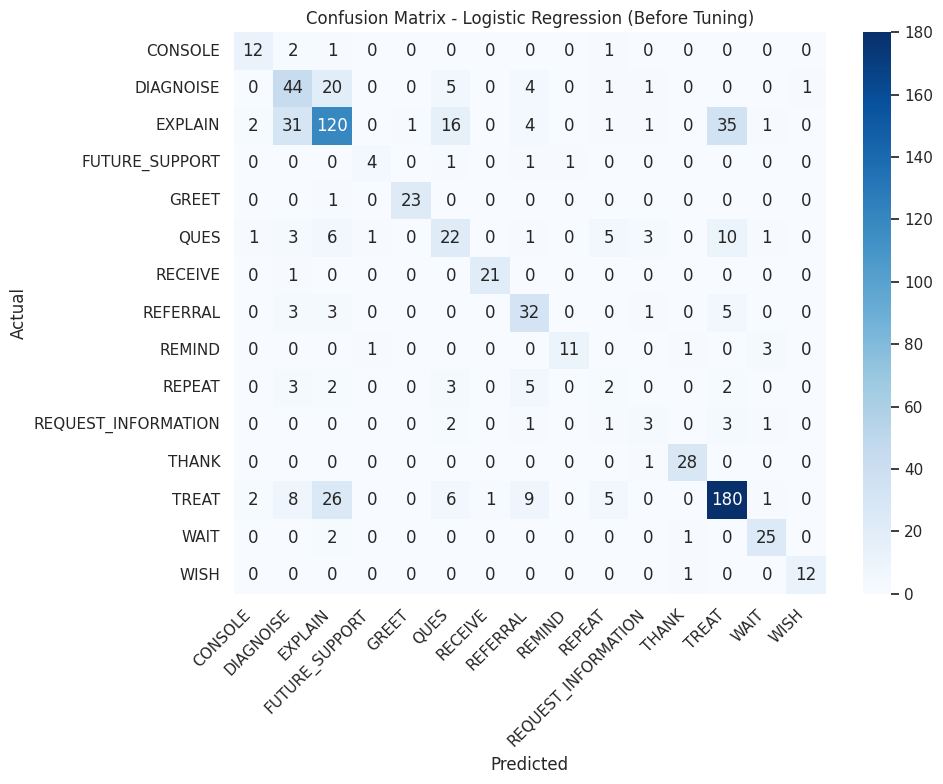


Logistic Regression (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.81      0.81      0.81        16
          DIAGNOISE       0.54      0.50      0.52        76
            EXPLAIN       0.59      0.63      0.61       212
     FUTURE_SUPPORT       0.57      0.57      0.57         7
              GREET       0.96      0.96      0.96        24
               QUES       0.37      0.36      0.37        53
            RECEIVE       0.91      0.91      0.91        22
           REFERRAL       0.58      0.50      0.54        44
             REMIND       0.83      0.62      0.71        16
             REPEAT       0.17      0.12      0.14        17
REQUEST_INFORMATION       0.25      0.18      0.21        11
              THANK       0.80      0.97      0.88        29
              TREAT       0.73      0.74      0.74       238
               WAIT       0.82      0.82      0.82        28
               WISH      

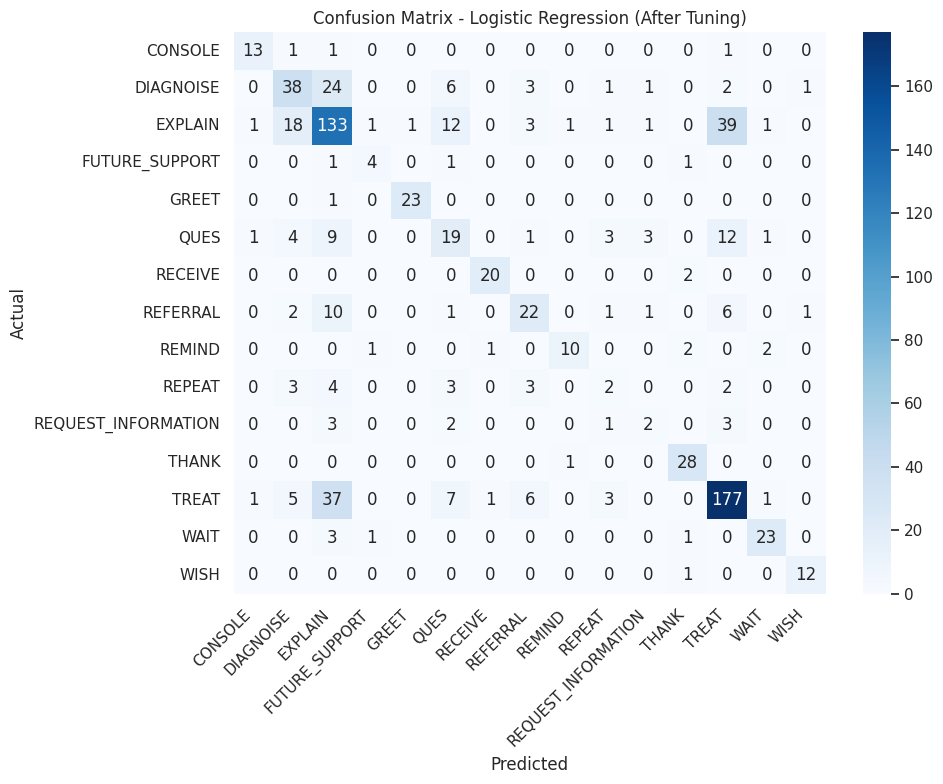


Logistic Regression (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.81      0.81      0.81        16
          DIAGNOISE       0.54      0.50      0.52        76
            EXPLAIN       0.59      0.63      0.61       212
     FUTURE_SUPPORT       0.57      0.57      0.57         7
              GREET       0.96      0.96      0.96        24
               QUES       0.37      0.36      0.37        53
            RECEIVE       0.91      0.91      0.91        22
           REFERRAL       0.58      0.50      0.54        44
             REMIND       0.83      0.62      0.71        16
             REPEAT       0.17      0.12      0.14        17
REQUEST_INFORMATION       0.25      0.18      0.21        11
              THANK       0.80      0.97      0.88        29
              TREAT       0.73      0.74      0.74       238
               WAIT       0.82      0.82      0.82        28
               WISH    

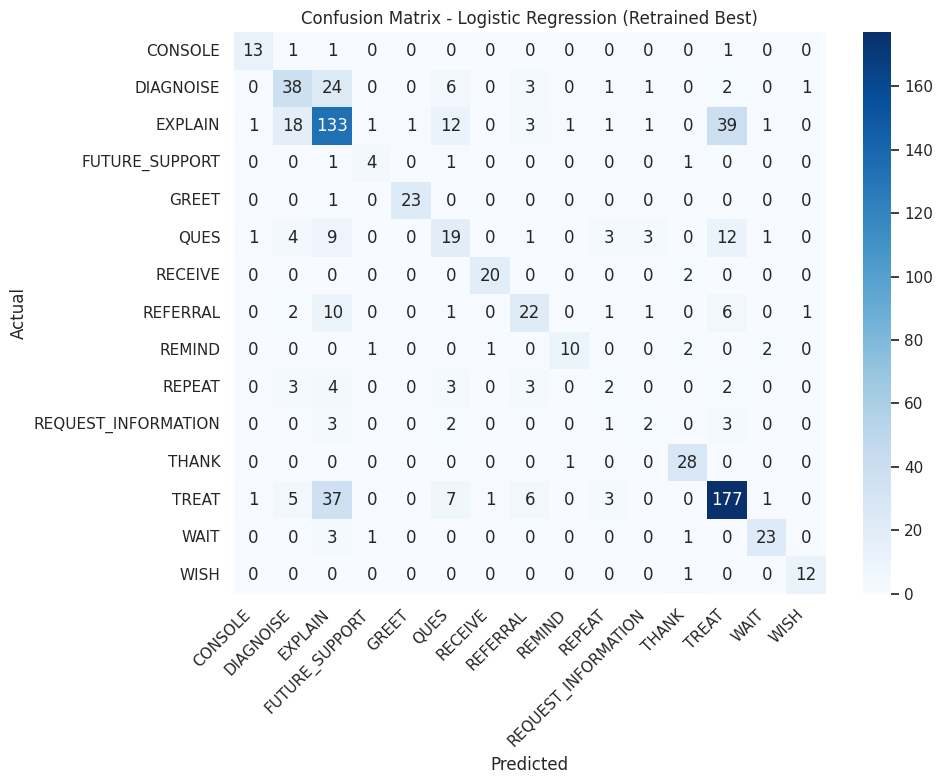

In [ ]:
# ------------------------------------------
# Modified Logistic Regression Training & Evaluation
# ------------------------------------------

print("\n===== Logistic Regression =====")

# 1. Train Basic Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set
y_val_pred = log_reg.predict(X_val_tfidf)
evaluate_model("Logistic Regression (Before Tuning)", log_reg, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - Logistic Regression (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"C": [0.01, 0.1, 1, 10, 100]}
log_reg_cv = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
log_reg_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model
y_val_pred_cv = log_reg_cv.predict(X_val_tfidf)
evaluate_model("Logistic Regression (After Tuning)", log_reg_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - Logistic Regression (After Tuning)")


# 3. Retrain with Best Hyperparameters
log_reg_final = LogisticRegression(C=log_reg_cv.best_params_['C'], max_iter=1000)
log_reg_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation
y_val_pred_final = log_reg_final.predict(X_val_tfidf)
evaluate_model("Logistic Regression (Retrained Best)", log_reg_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - Logistic Regression (Retrained Best)")


### Support Vector Classifier: Training, Hyperparameter Tuning, and Evaluation
Support Vector Classifier (SVC) was trained using TF-IDF feature representations extracted from the cleaned text data. The initial model achieved a validation accuracy of 65.00%. Hyperparameter tuning was performed using GridSearchCV to optimize the regularization parameter C and kernel type, with the best configuration yielding a final validation accuracy of 64.39% and a weighted F1-score of 61.62%. Although SVC showed reasonable precision and recall for frequent classes like GREET and TREAT, it struggled to accurately classify low-frequency classes such as REPEAT and REQUEST_INFORMATION.


===== Support Vector Classifier =====

SVC (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.85      0.69      0.76        16
          DIAGNOISE       0.76      0.21      0.33        76
            EXPLAIN       0.48      0.78      0.59       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.92      0.96      0.94        24
               QUES       0.89      0.15      0.26        53
            RECEIVE       0.95      0.91      0.93        22
           REFERRAL       0.64      0.20      0.31        44
             REMIND       0.90      0.56      0.69        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       1.00      0.09      0.17        11
              THANK       0.87      0.93      0.90        29
              TREAT       0.70      0.82      0.75       238
               WAIT       0.90      0.68      0.78        28
 

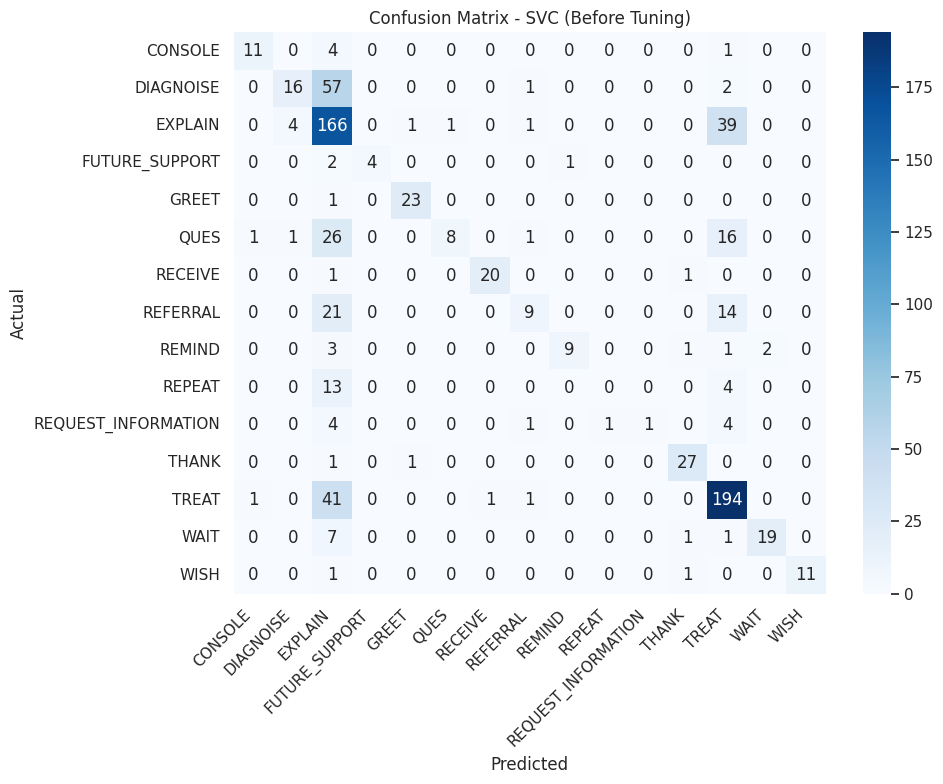


SVC (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.85      0.69      0.76        16
          DIAGNOISE       0.73      0.29      0.42        76
            EXPLAIN       0.49      0.76      0.60       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.96      0.96      0.96        24
               QUES       0.58      0.21      0.31        53
            RECEIVE       0.95      0.91      0.93        22
           REFERRAL       0.62      0.18      0.28        44
             REMIND       0.90      0.56      0.69        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       1.00      0.09      0.17        11
              THANK       0.87      0.93      0.90        29
              TREAT       0.69      0.80      0.74       238
               WAIT       0.90      0.68      0.78        28
               WISH       1.00      0.85 

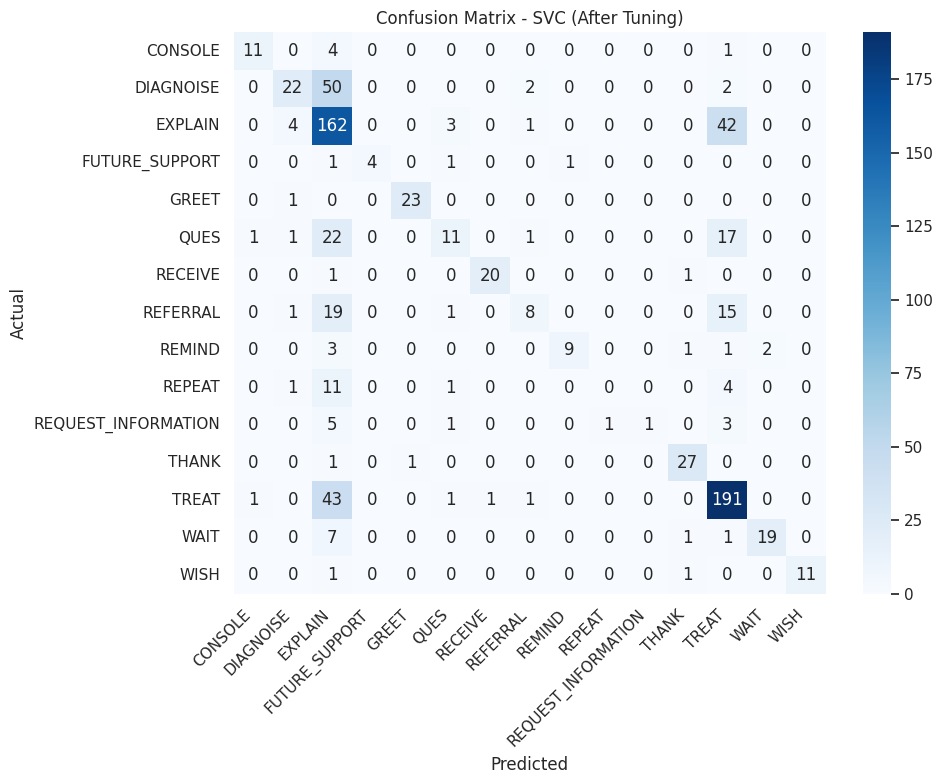


SVC (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.85      0.69      0.76        16
          DIAGNOISE       0.73      0.29      0.42        76
            EXPLAIN       0.49      0.76      0.60       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.96      0.96      0.96        24
               QUES       0.58      0.21      0.31        53
            RECEIVE       0.95      0.91      0.93        22
           REFERRAL       0.62      0.18      0.28        44
             REMIND       0.90      0.56      0.69        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       1.00      0.09      0.17        11
              THANK       0.87      0.93      0.90        29
              TREAT       0.69      0.80      0.74       238
               WAIT       0.90      0.68      0.78        28
               WISH       1.00      0.8

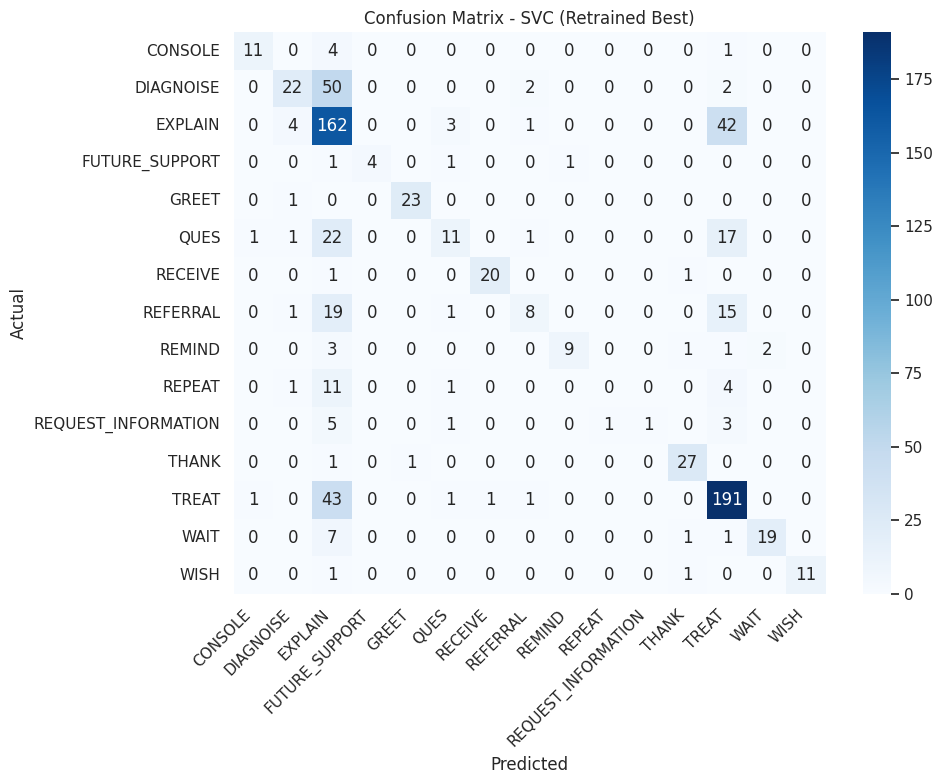

In [ ]:
print("\n===== Support Vector Classifier =====")

# 1. Train Basic SVC
svc = SVC()
svc.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = svc.predict(X_val_tfidf)
evaluate_model("SVC (Before Tuning)", svc, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - SVC (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"C": [0.01, 0.1, 1, 10], "kernel": ['linear', 'rbf']}
svc_cv = GridSearchCV(SVC(), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
svc_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = svc_cv.predict(X_val_tfidf)
evaluate_model("SVC (After Tuning)", svc_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - SVC (After Tuning)")


# 3. Retrain with Best Hyperparameters
svc_final = SVC(C=svc_cv.best_params_['C'], kernel=svc_cv.best_params_['kernel'])
svc_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = svc_final.predict(X_val_tfidf)
evaluate_model("SVC (Retrained Best)", svc_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - SVC (Retrained Best)")


### K-Nearest Neighbors: Training, Hyperparameter Tuning, and Evaluation
K-Nearest Neighbors (KNN) was trained using TF-IDF vectorized sentence representations. Initial training and hyperparameter tuning (optimizing the number of neighbors) were performed using GridSearchCV. Despite tuning, the final retrained model achieved a low validation accuracy of 28.16% and a weighted F1-score of 24.03%. KNN struggled to classify the majority of classes correctly, especially frequent categories like TREAT and EXPLAIN, likely due to the high-dimensional sparse nature of TF-IDF features.


===== K-Nearest Neighbors =====

KNN (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.54      0.81      0.65        16
          DIAGNOISE       0.20      0.49      0.28        76
            EXPLAIN       0.38      0.01      0.03       212
     FUTURE_SUPPORT       0.80      0.57      0.67         7
              GREET       0.82      0.96      0.88        24
               QUES       0.10      0.72      0.17        53
            RECEIVE       0.75      0.82      0.78        22
           REFERRAL       0.47      0.16      0.24        44
             REMIND       0.75      0.38      0.50        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       0.12      0.09      0.11        11
              THANK       0.73      0.93      0.82        29
              TREAT       0.50      0.02      0.03       238
               WAIT       0.84      0.75      0.79        28
       

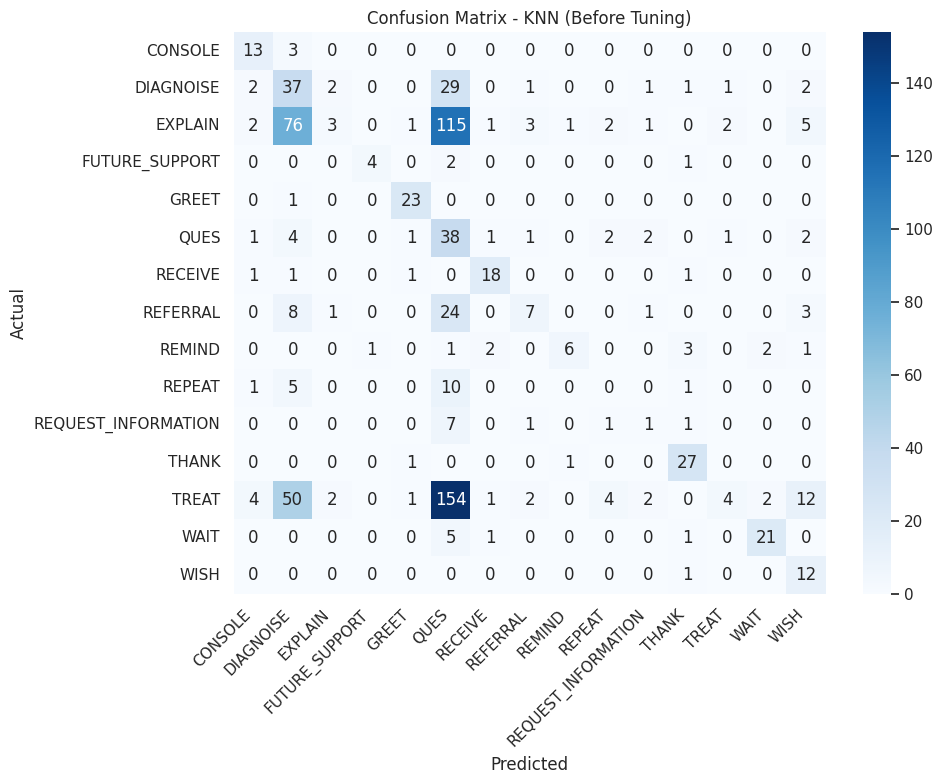


KNN (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.57      0.81      0.67        16
          DIAGNOISE       0.18      0.50      0.26        76
            EXPLAIN       0.56      0.05      0.09       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.82      0.96      0.88        24
               QUES       0.11      0.68      0.18        53
            RECEIVE       0.78      0.82      0.80        22
           REFERRAL       0.44      0.16      0.23        44
             REMIND       0.78      0.44      0.56        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       0.12      0.09      0.11        11
              THANK       0.75      0.93      0.83        29
              TREAT       0.92      0.05      0.09       238
               WAIT       0.81      0.75      0.78        28
               WISH       0.26      0.92 

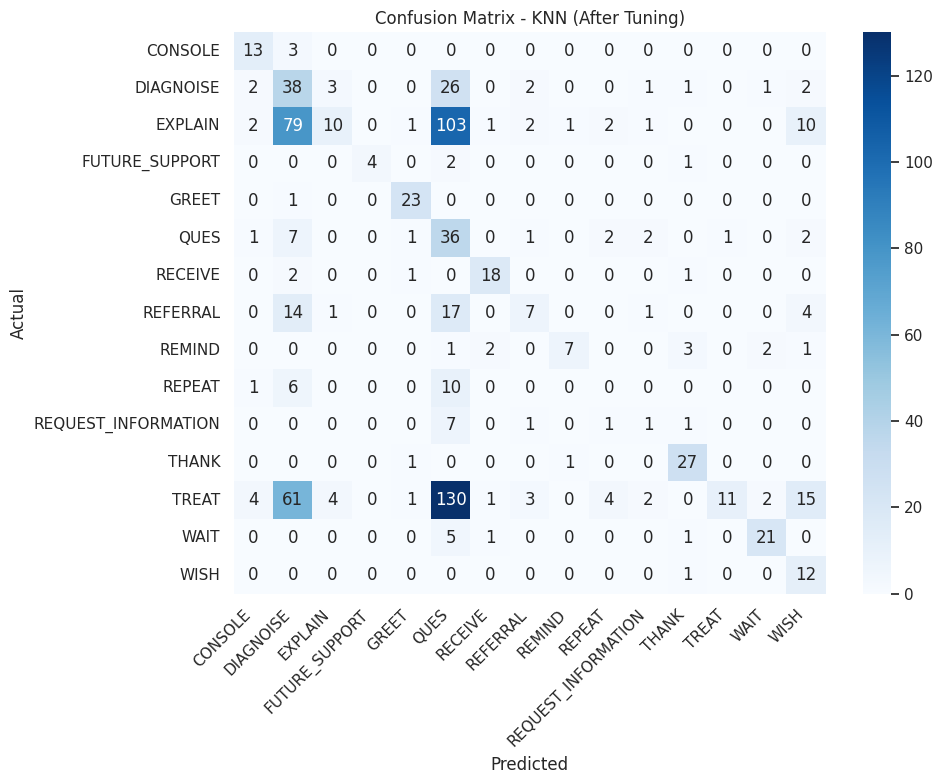


KNN (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.57      0.81      0.67        16
          DIAGNOISE       0.18      0.50      0.26        76
            EXPLAIN       0.56      0.05      0.09       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.82      0.96      0.88        24
               QUES       0.11      0.68      0.18        53
            RECEIVE       0.78      0.82      0.80        22
           REFERRAL       0.44      0.16      0.23        44
             REMIND       0.78      0.44      0.56        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       0.12      0.09      0.11        11
              THANK       0.75      0.93      0.83        29
              TREAT       0.92      0.05      0.09       238
               WAIT       0.81      0.75      0.78        28
               WISH       0.26      0.9

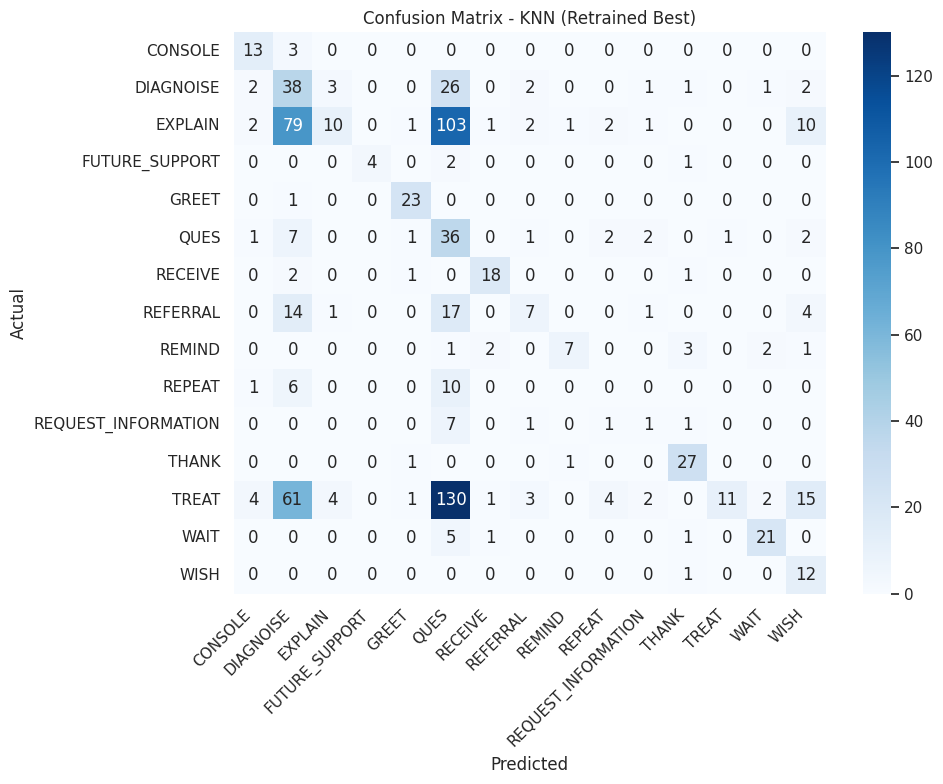

In [ ]:
print("\n===== K-Nearest Neighbors =====")

# 1. Train Basic KNN
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = knn.predict(X_val_tfidf)
evaluate_model("KNN (Before Tuning)", knn, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - KNN (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"n_neighbors": [3, 5, 7, 9]}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
knn_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = knn_cv.predict(X_val_tfidf)
evaluate_model("KNN (After Tuning)", knn_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - KNN (After Tuning)")


# 3. Retrain with Best Hyperparameters
knn_final = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = knn_final.predict(X_val_tfidf)
evaluate_model("KNN (Retrained Best)", knn_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - KNN (Retrained Best)")


### Decision Tree: Training, Hyperparameter Tuning, and Evaluation
A Decision Tree classifier was trained on TF-IDF features extracted from the cleaned dataset. After an initial training phase, hyperparameter tuning was performed by optimizing the maximum tree depth using GridSearchCV. The retrained Decision Tree model achieved a validation accuracy of 55.09% and a weighted F1-score of 55.30%. While the model performed decently for classes such as GREET and THANK, it struggled with precision and recall across less frequent or more ambiguous classes like REPEAT and REQUEST_INFORMATION.


===== Decision Tree =====

Decision Tree (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.75      0.75      0.75        16
          DIAGNOISE       0.36      0.37      0.36        76
            EXPLAIN       0.53      0.38      0.44       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.85      0.96      0.90        24
               QUES       0.22      0.45      0.30        53
            RECEIVE       0.86      0.86      0.86        22
           REFERRAL       0.43      0.34      0.38        44
             REMIND       0.54      0.44      0.48        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       0.24      0.36      0.29        11
              THANK       0.82      0.97      0.89        29
              TREAT       0.63      0.63      0.63       238
               WAIT       0.61      0.68      0.64        28
   

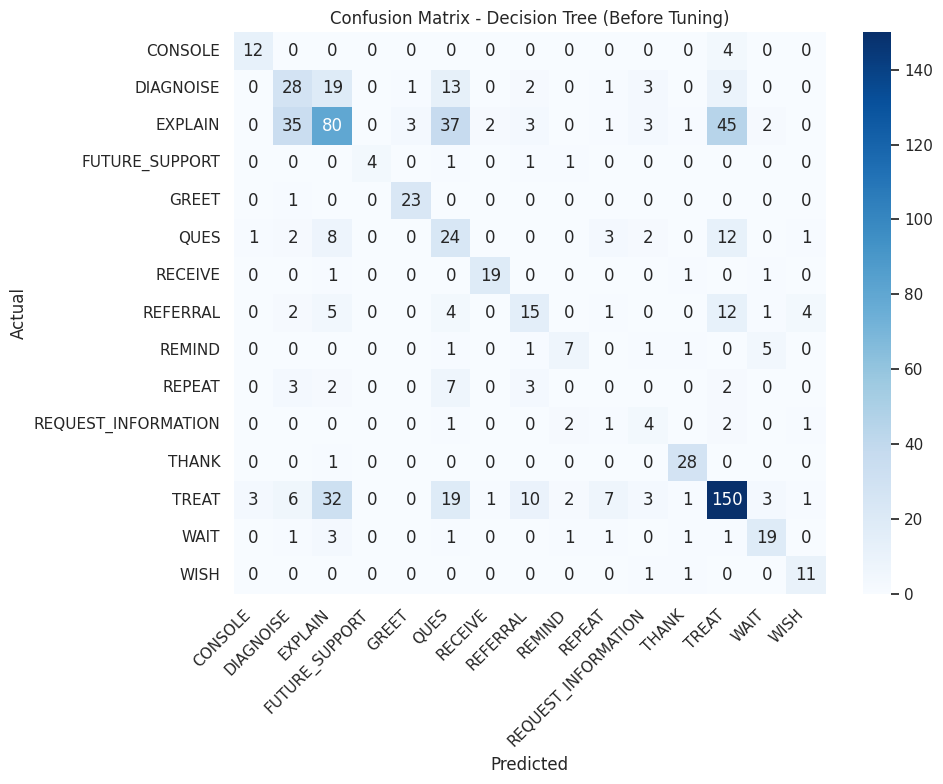


Decision Tree (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.73      0.69      0.71        16
          DIAGNOISE       0.36      0.41      0.39        76
            EXPLAIN       0.52      0.41      0.46       212
     FUTURE_SUPPORT       0.80      0.57      0.67         7
              GREET       0.85      0.96      0.90        24
               QUES       0.22      0.43      0.29        53
            RECEIVE       0.90      0.86      0.88        22
           REFERRAL       0.43      0.34      0.38        44
             REMIND       0.50      0.38      0.43        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       0.29      0.36      0.32        11
              THANK       0.87      0.93      0.90        29
              TREAT       0.64      0.62      0.63       238
               WAIT       0.69      0.71      0.70        28
               WISH       0.58 

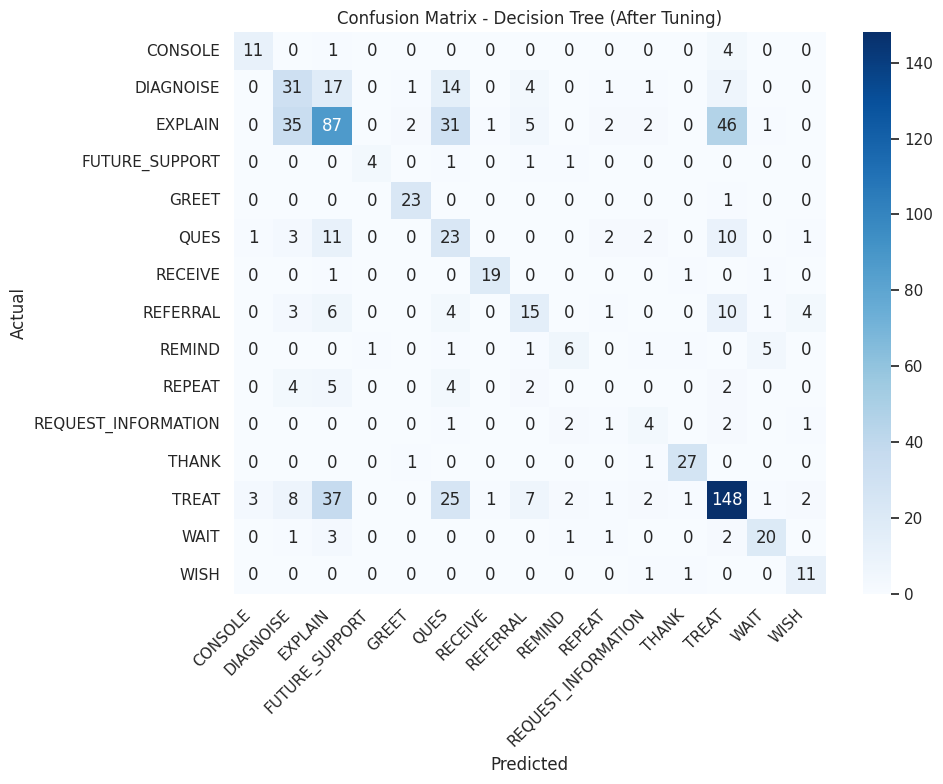


Decision Tree (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.71      0.75      0.73        16
          DIAGNOISE       0.36      0.39      0.38        76
            EXPLAIN       0.53      0.39      0.45       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.85      0.96      0.90        24
               QUES       0.22      0.47      0.30        53
            RECEIVE       0.90      0.86      0.88        22
           REFERRAL       0.43      0.30      0.35        44
             REMIND       0.50      0.44      0.47        16
             REPEAT       0.17      0.18      0.17        17
REQUEST_INFORMATION       0.29      0.36      0.32        11
              THANK       0.84      0.93      0.89        29
              TREAT       0.64      0.61      0.63       238
               WAIT       0.65      0.71      0.68        28
               WISH       0.5

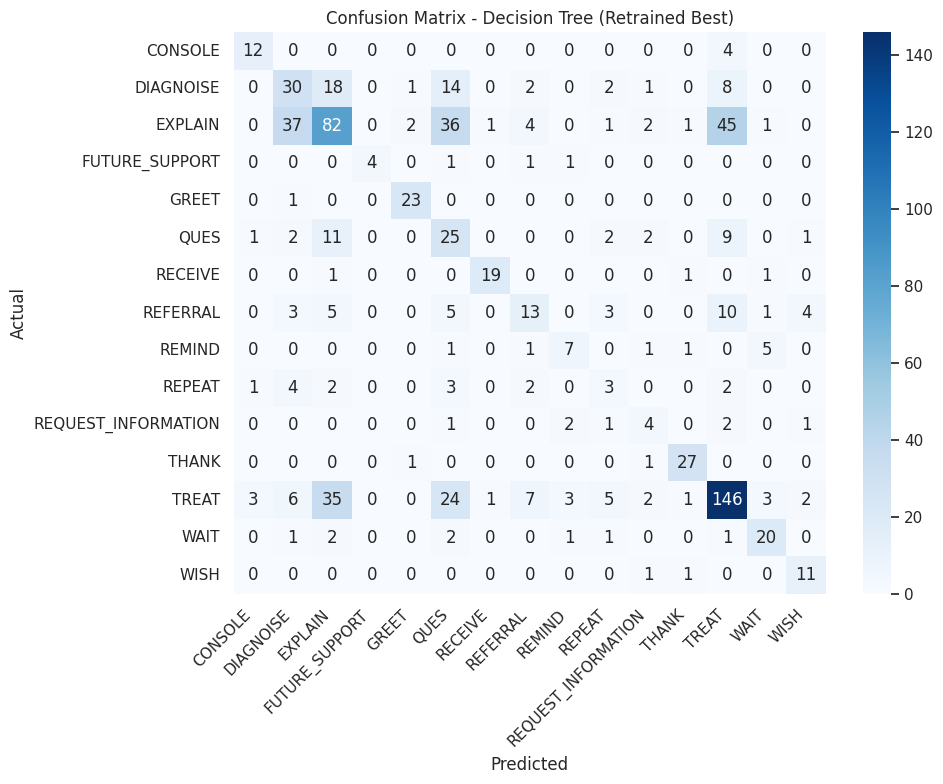

In [ ]:
print("\n===== Decision Tree =====")

# 1. Train Basic Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = dt.predict(X_val_tfidf)
evaluate_model("Decision Tree (Before Tuning)", dt, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - Decision Tree (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"max_depth": [10, 20, 30, None]}
dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
dt_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = dt_cv.predict(X_val_tfidf)
evaluate_model("Decision Tree (After Tuning)", dt_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - Decision Tree (After Tuning)")


# 3. Retrain with Best Hyperparameters
dt_final = DecisionTreeClassifier(max_depth=dt_cv.best_params_['max_depth'])
dt_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = dt_final.predict(X_val_tfidf)
evaluate_model("Decision Tree (Retrained Best)", dt_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - Decision Tree (Retrained Best)")


### Random Forest: Training, Hyperparameter Tuning, and Evaluation
A Random Forest classifier was trained using TF-IDF feature representations. Hyperparameter tuning was conducted via GridSearchCV to optimize the number of trees (n_estimators) and maximum depth (max_depth) of each tree. After tuning, the retrained Random Forest model achieved a validation accuracy of 62.03% and a weighted F1-score of 62.05%. The model demonstrated balanced performance across several classes, performing particularly well on GREET, THANK, and TREAT categories.


===== Random Forest =====

Random Forest (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.67      0.75      0.71        16
          DIAGNOISE       0.49      0.46      0.48        76
            EXPLAIN       0.65      0.45      0.53       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.92      0.96      0.94        24
               QUES       0.25      0.58      0.35        53
            RECEIVE       0.73      0.86      0.79        22
           REFERRAL       0.52      0.52      0.52        44
             REMIND       0.83      0.62      0.71        16
             REPEAT       0.33      0.06      0.10        17
REQUEST_INFORMATION       0.60      0.27      0.38        11
              THANK       0.88      0.97      0.92        29
              TREAT       0.73      0.77      0.75       238
               WAIT       0.77      0.71      0.74        28
   

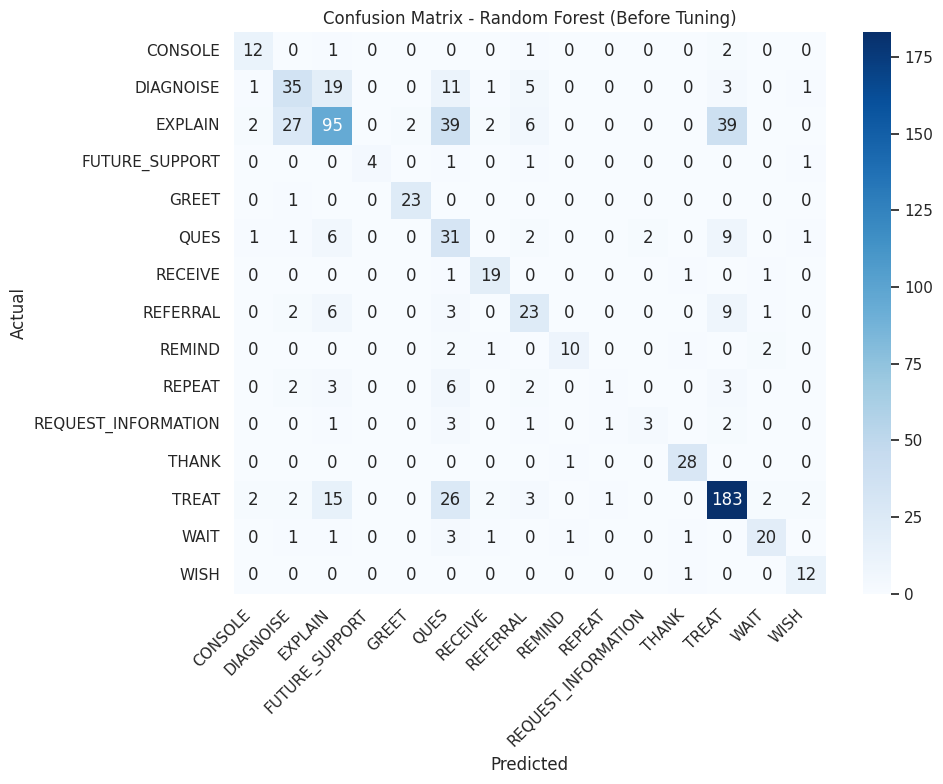


Random Forest (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.80      0.75      0.77        16
          DIAGNOISE       0.45      0.39      0.42        76
            EXPLAIN       0.63      0.44      0.52       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.92      0.96      0.94        24
               QUES       0.25      0.58      0.35        53
            RECEIVE       0.73      0.86      0.79        22
           REFERRAL       0.60      0.59      0.60        44
             REMIND       0.77      0.62      0.69        16
             REPEAT       0.20      0.06      0.09        17
REQUEST_INFORMATION       0.50      0.27      0.35        11
              THANK       0.85      0.97      0.90        29
              TREAT       0.70      0.75      0.72       238
               WAIT       0.79      0.68      0.73        28
               WISH       0.71 

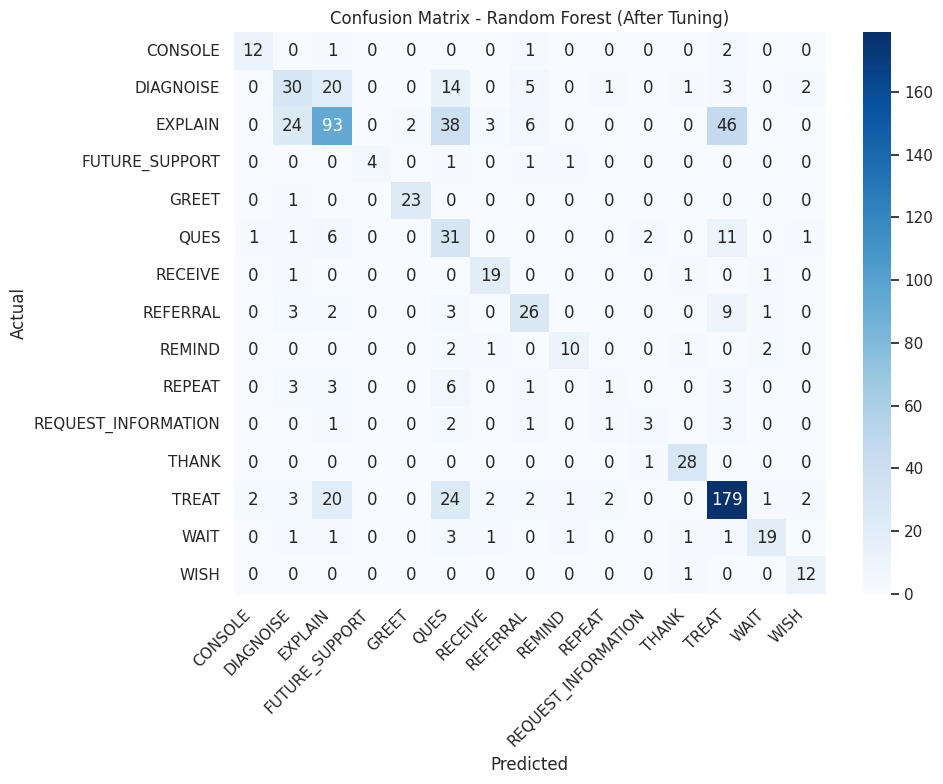


Random Forest (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.76      0.81      0.79        16
          DIAGNOISE       0.49      0.43      0.46        76
            EXPLAIN       0.65      0.47      0.54       212
     FUTURE_SUPPORT       0.80      0.57      0.67         7
              GREET       0.92      0.96      0.94        24
               QUES       0.27      0.55      0.36        53
            RECEIVE       0.66      0.86      0.75        22
           REFERRAL       0.60      0.59      0.60        44
             REMIND       0.80      0.50      0.62        16
             REPEAT       0.25      0.06      0.10        17
REQUEST_INFORMATION       0.50      0.27      0.35        11
              THANK       0.88      0.97      0.92        29
              TREAT       0.71      0.79      0.75       238
               WAIT       0.72      0.75      0.74        28
               WISH       0.7

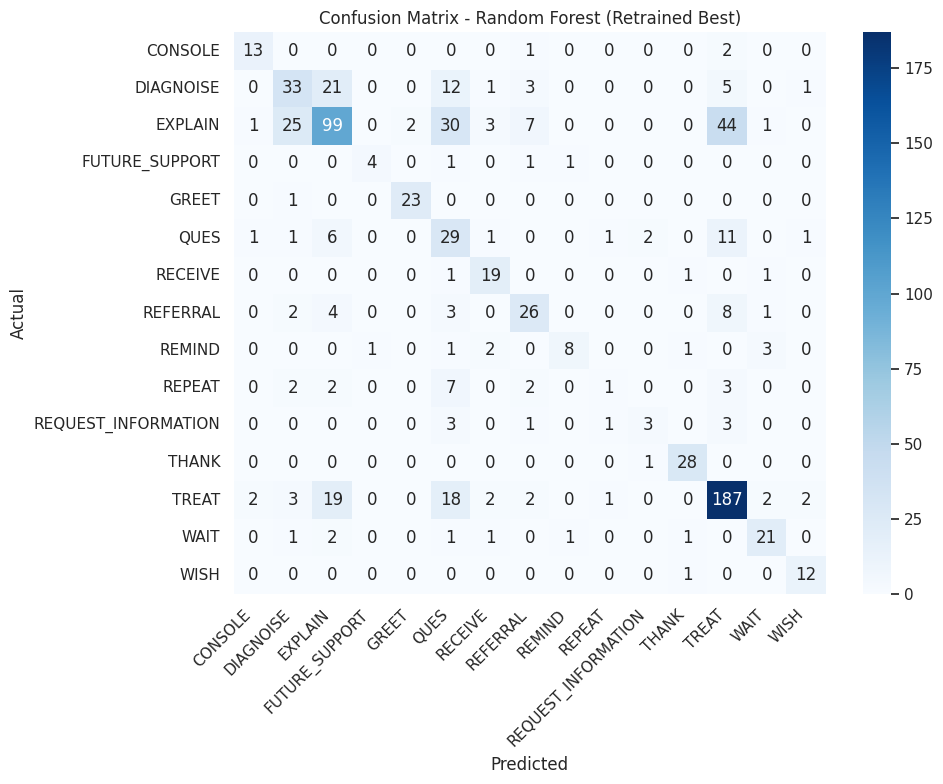

In [ ]:
print("\n===== Random Forest =====")

# 1. Train Basic Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = rf.predict(X_val_tfidf)
evaluate_model("Random Forest (Before Tuning)", rf, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - Random Forest (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"n_estimators": [100, 200], "max_depth": [10, 20, None]}
rf_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
rf_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = rf_cv.predict(X_val_tfidf)
evaluate_model("Random Forest (After Tuning)", rf_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - Random Forest (After Tuning)")


# 3. Retrain with Best Hyperparameters
rf_final = RandomForestClassifier(
    n_estimators=rf_cv.best_params_['n_estimators'],
    max_depth=rf_cv.best_params_['max_depth']
)
rf_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = rf_final.predict(X_val_tfidf)
evaluate_model("Random Forest (Retrained Best)", rf_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - Random Forest (Retrained Best)")


### Extra Trees: Training, Hyperparameter Tuning, and Evaluation
An Extra Trees classifier was trained using TF-IDF feature representations extracted from the cleaned text data. Hyperparameter tuning using GridSearchCV was employed to optimize the number of estimators and tree depth. The retrained model achieved a validation accuracy of 63.90% and a weighted F1-score of 63.65%. The model demonstrated strong performance across several frequent classes like GREET, THANK, and TREAT, while still facing challenges with minority classes such as REPEAT and REQUEST_INFORMATION.


===== Extra Trees =====

Extra Trees (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.63      0.75      0.69        16
          DIAGNOISE       0.52      0.51      0.52        76
            EXPLAIN       0.68      0.46      0.55       212
     FUTURE_SUPPORT       0.67      0.57      0.62         7
              GREET       0.96      0.96      0.96        24
               QUES       0.33      0.62      0.43        53
            RECEIVE       0.75      0.95      0.84        22
           REFERRAL       0.53      0.59      0.56        44
             REMIND       0.67      0.62      0.65        16
             REPEAT       0.38      0.18      0.24        17
REQUEST_INFORMATION       0.60      0.27      0.38        11
              THANK       0.85      0.97      0.90        29
              TREAT       0.70      0.76      0.73       238
               WAIT       0.79      0.79      0.79        28
       

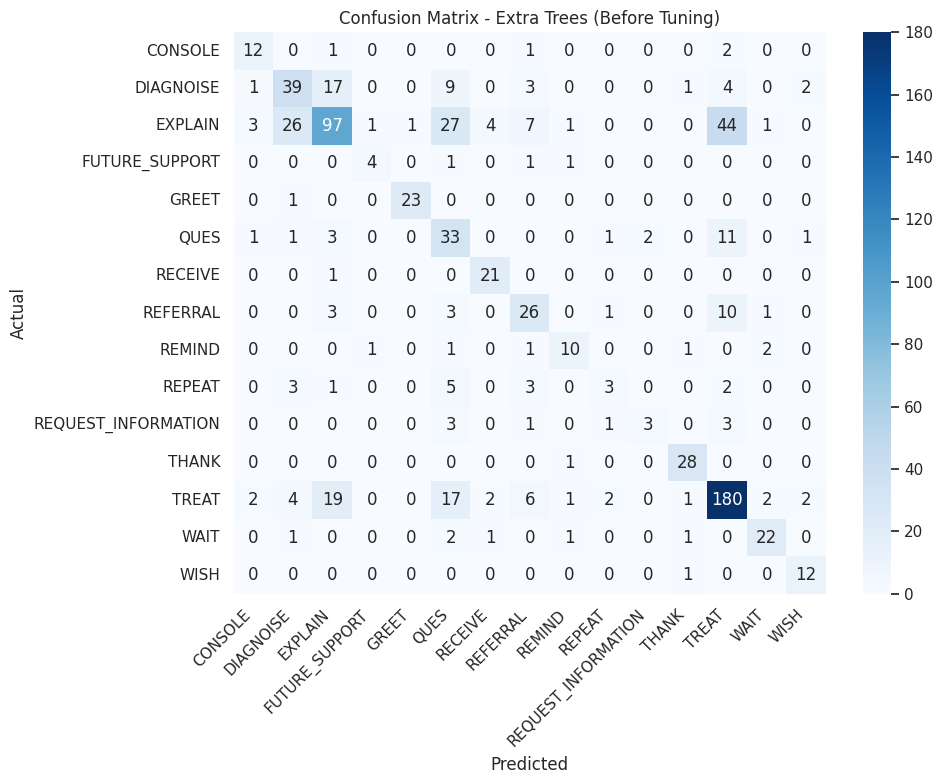


Extra Trees (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.67      0.75      0.71        16
          DIAGNOISE       0.51      0.53      0.52        76
            EXPLAIN       0.69      0.47      0.56       212
     FUTURE_SUPPORT       1.00      0.57      0.73         7
              GREET       0.96      0.96      0.96        24
               QUES       0.32      0.60      0.42        53
            RECEIVE       0.74      0.91      0.82        22
           REFERRAL       0.53      0.57      0.55        44
             REMIND       0.83      0.62      0.71        16
             REPEAT       0.38      0.18      0.24        17
REQUEST_INFORMATION       0.50      0.27      0.35        11
              THANK       0.82      0.97      0.89        29
              TREAT       0.71      0.77      0.74       238
               WAIT       0.80      0.86      0.83        28
               WISH       0.67   

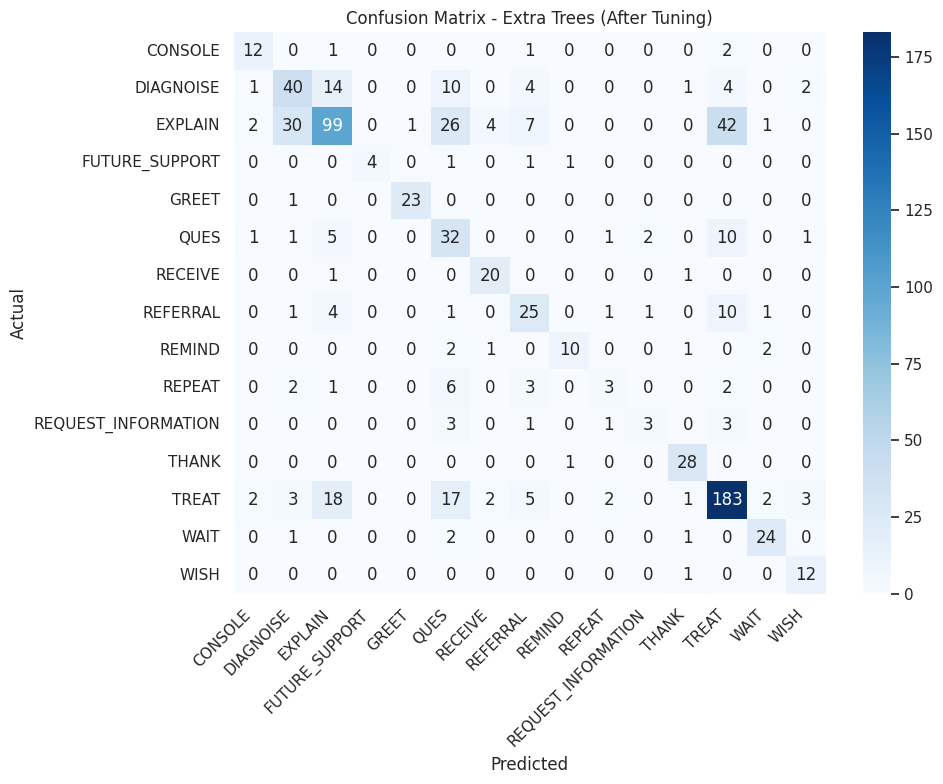


Extra Trees (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.67      0.75      0.71        16
          DIAGNOISE       0.49      0.51      0.50        76
            EXPLAIN       0.68      0.45      0.54       212
     FUTURE_SUPPORT       0.67      0.57      0.62         7
              GREET       0.96      0.96      0.96        24
               QUES       0.33      0.62      0.43        53
            RECEIVE       0.74      0.91      0.82        22
           REFERRAL       0.53      0.59      0.56        44
             REMIND       0.77      0.62      0.69        16
             REPEAT       0.38      0.18      0.24        17
REQUEST_INFORMATION       0.60      0.27      0.38        11
              THANK       0.82      0.97      0.89        29
              TREAT       0.70      0.74      0.72       238
               WAIT       0.77      0.86      0.81        28
               WISH       0.67 

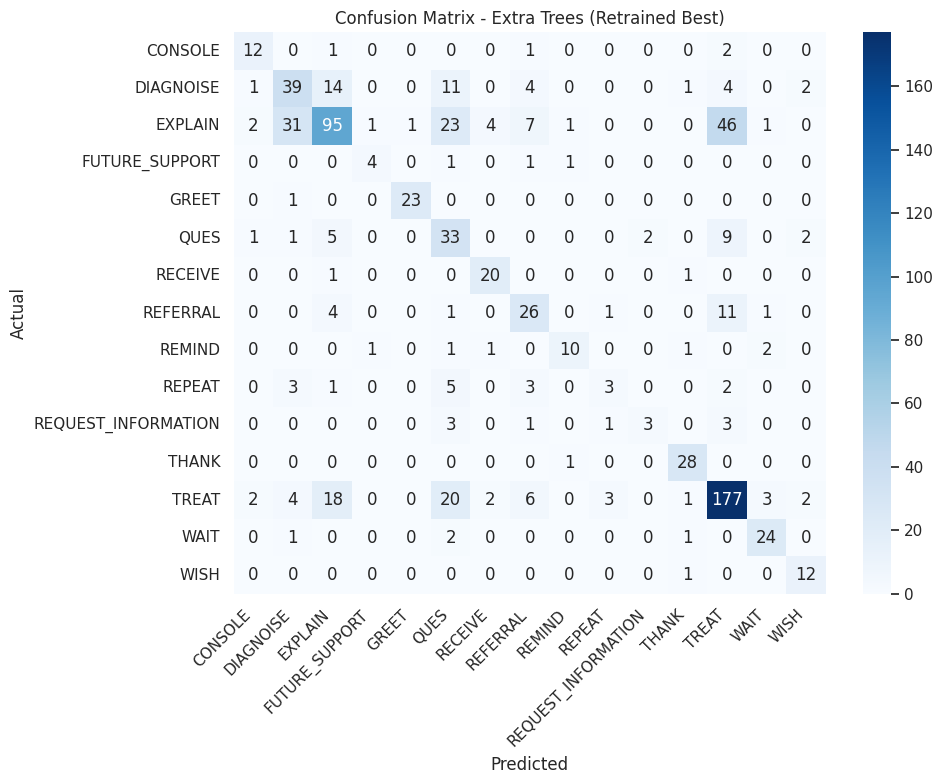

In [ ]:
print("\n===== Extra Trees =====")

# 1. Train Basic Extra Trees
et = ExtraTreesClassifier()
et.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = et.predict(X_val_tfidf)
evaluate_model("Extra Trees (Before Tuning)", et, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - Extra Trees (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"n_estimators": [100, 200], "max_depth": [10, 20, None]}
et_cv = GridSearchCV(ExtraTreesClassifier(), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
et_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = et_cv.predict(X_val_tfidf)
evaluate_model("Extra Trees (After Tuning)", et_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - Extra Trees (After Tuning)")


# 3. Retrain with Best Hyperparameters
et_final = ExtraTreesClassifier(
    n_estimators=et_cv.best_params_['n_estimators'],
    max_depth=et_cv.best_params_['max_depth']
)
et_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = et_final.predict(X_val_tfidf)
evaluate_model("Extra Trees (Retrained Best)", et_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - Extra Trees (Retrained Best)")



===== XGBoost =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:43:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.80      0.75      0.77        16
          DIAGNOISE       0.54      0.57      0.55        76
            EXPLAIN       0.59      0.55      0.57       212
     FUTURE_SUPPORT       1.00      0.29      0.44         7
              GREET       0.92      0.96      0.94        24
               QUES       0.27      0.51      0.36        53
            RECEIVE       0.83      0.91      0.87        22
           REFERRAL       0.64      0.52      0.57        44
             REMIND       0.64      0.44      0.52        16
             REPEAT       0.00      0.00      0.00        17
REQUEST_INFORMATION       0.71      0.45      0.56        11
              THANK       0.88      0.97      0.92        29
              TREAT       0.74      0.74      0.74       238
               WAIT       0.80      0.71      0.75        28
               WISH       0.92      

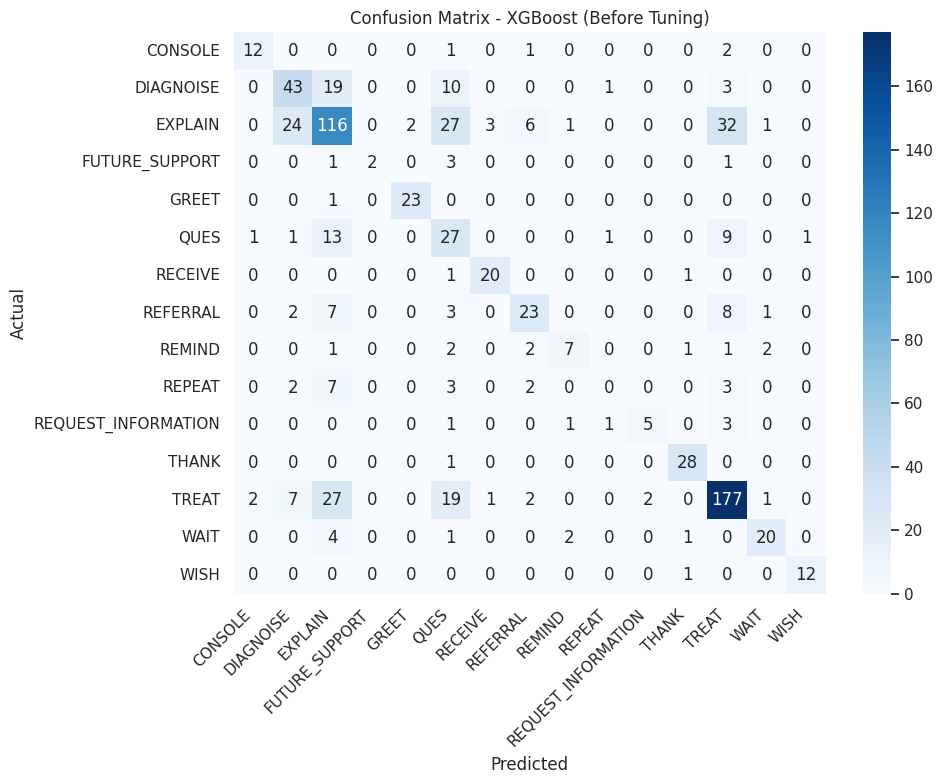

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:02:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.80      0.75      0.77        16
          DIAGNOISE       0.59      0.47      0.53        76
            EXPLAIN       0.56      0.59      0.57       212
     FUTURE_SUPPORT       0.60      0.43      0.50         7
              GREET       0.92      0.96      0.94        24
               QUES       0.36      0.43      0.39        53
            RECEIVE       0.84      0.95      0.89        22
           REFERRAL       0.67      0.59      0.63        44
             REMIND       0.64      0.44      0.52        16
             REPEAT       0.29      0.12      0.17        17
REQUEST_INFORMATION       0.71      0.45      0.56        11
              THANK       0.90      0.97      0.93        29
              TREAT       0.72      0.76      0.74       238
               WAIT       0.80      0.71      0.75        28
               WISH       0.92      0

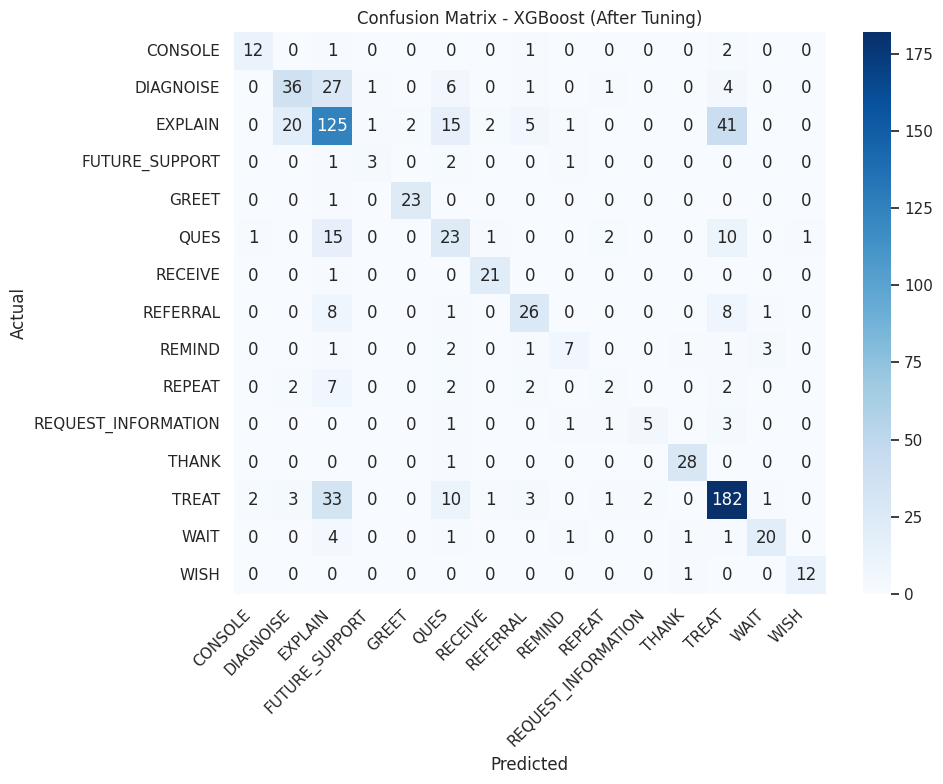

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:03:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.80      0.75      0.77        16
          DIAGNOISE       0.59      0.47      0.53        76
            EXPLAIN       0.56      0.59      0.57       212
     FUTURE_SUPPORT       0.60      0.43      0.50         7
              GREET       0.92      0.96      0.94        24
               QUES       0.36      0.43      0.39        53
            RECEIVE       0.84      0.95      0.89        22
           REFERRAL       0.67      0.59      0.63        44
             REMIND       0.64      0.44      0.52        16
             REPEAT       0.29      0.12      0.17        17
REQUEST_INFORMATION       0.71      0.45      0.56        11
              THANK       0.90      0.97      0.93        29
              TREAT       0.72      0.76      0.74       238
               WAIT       0.80      0.71      0.75        28
               WISH       0.92     

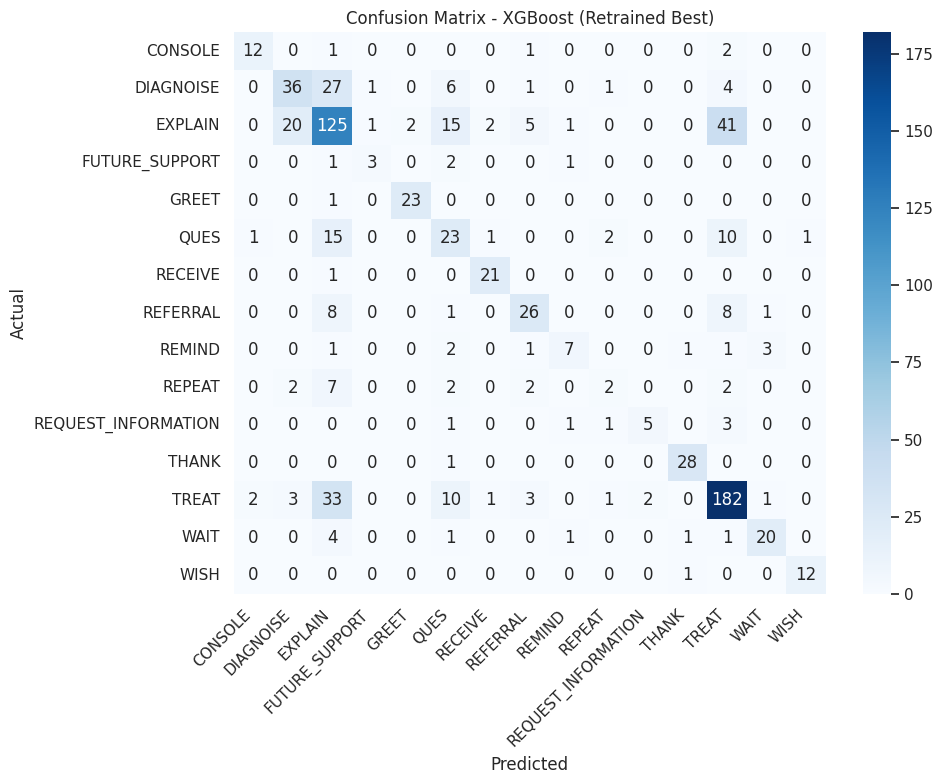

In [ ]:
print("\n===== XGBoost =====")

# 1. Train Basic XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = xgb_clf.predict(X_val_tfidf)
evaluate_model("XGBoost (Before Tuning)", xgb_clf, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - XGBoost (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"n_estimators": [100, 200], "max_depth": [3, 6, 9]}
xgb_cv = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
xgb_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = xgb_cv.predict(X_val_tfidf)
evaluate_model("XGBoost (After Tuning)", xgb_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - XGBoost (After Tuning)")


# 3. Retrain with Best Hyperparameters
xgb_final = xgb.XGBClassifier(
    n_estimators=xgb_cv.best_params_['n_estimators'],
    max_depth=xgb_cv.best_params_['max_depth'],
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = xgb_final.predict(X_val_tfidf)
evaluate_model("XGBoost (Retrained Best)", xgb_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - XGBoost (Retrained Best)")


### Naive Bayes: Training and Evaluation
A Multinomial Naive Bayes classifier was trained directly on the TF-IDF feature set without the need for hyperparameter tuning. The model achieved a validation accuracy of 60.92% and a weighted F1-score of 61.69%. Naive Bayes performed particularly well on classes like GREET, RECEIVE, THANK, and WISH, although it struggled with low-frequency and overlapping classes such as REPEAT and REQUEST_INFORMATION.


===== Naive Bayes =====

Naive Bayes Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.50      0.81      0.62        16
          DIAGNOISE       0.46      0.61      0.52        76
            EXPLAIN       0.73      0.42      0.54       212
     FUTURE_SUPPORT       0.36      0.57      0.44         7
              GREET       0.83      1.00      0.91        24
               QUES       0.59      0.32      0.41        53
            RECEIVE       0.84      0.95      0.89        22
           REFERRAL       0.40      0.75      0.52        44
             REMIND       0.58      0.69      0.63        16
             REPEAT       0.10      0.29      0.15        17
REQUEST_INFORMATION       0.15      0.27      0.19        11
              THANK       0.85      0.97      0.90        29
              TREAT       0.77      0.68      0.72       238
               WAIT       0.79      0.93      0.85        28
               WISH    

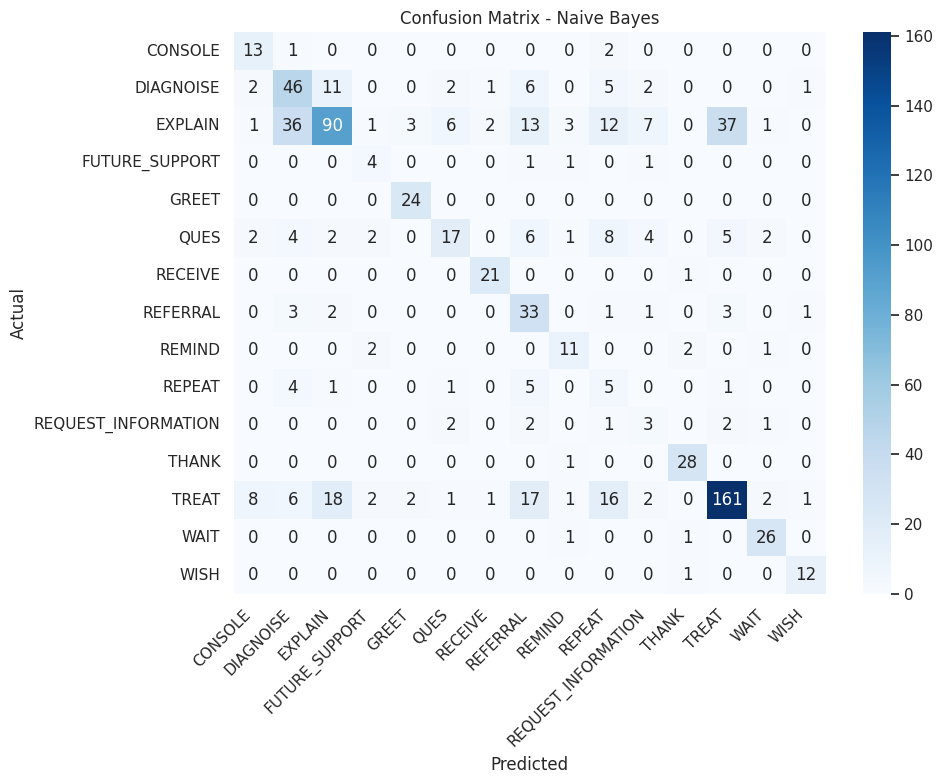

In [ ]:
print("\n===== Naive Bayes =====")

# 1. Train and Evaluate Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set
y_val_pred = nb.predict(X_val_tfidf)
evaluate_model("Naive Bayes", nb, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - Naive Bayes")



===== Ridge Classifier =====

Ridge Classifier (Before Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.68      0.81      0.74        16
          DIAGNOISE       0.51      0.58      0.54        76
            EXPLAIN       0.67      0.55      0.60       212
     FUTURE_SUPPORT       0.75      0.43      0.55         7
              GREET       0.88      0.96      0.92        24
               QUES       0.40      0.42      0.41        53
            RECEIVE       0.91      0.95      0.93        22
           REFERRAL       0.59      0.73      0.65        44
             REMIND       0.64      0.56      0.60        16
             REPEAT       0.11      0.12      0.11        17
REQUEST_INFORMATION       0.25      0.27      0.26        11
              THANK       0.85      0.97      0.90        29
              TREAT       0.76      0.75      0.75       238
               WAIT       0.73      0.86      0.79        

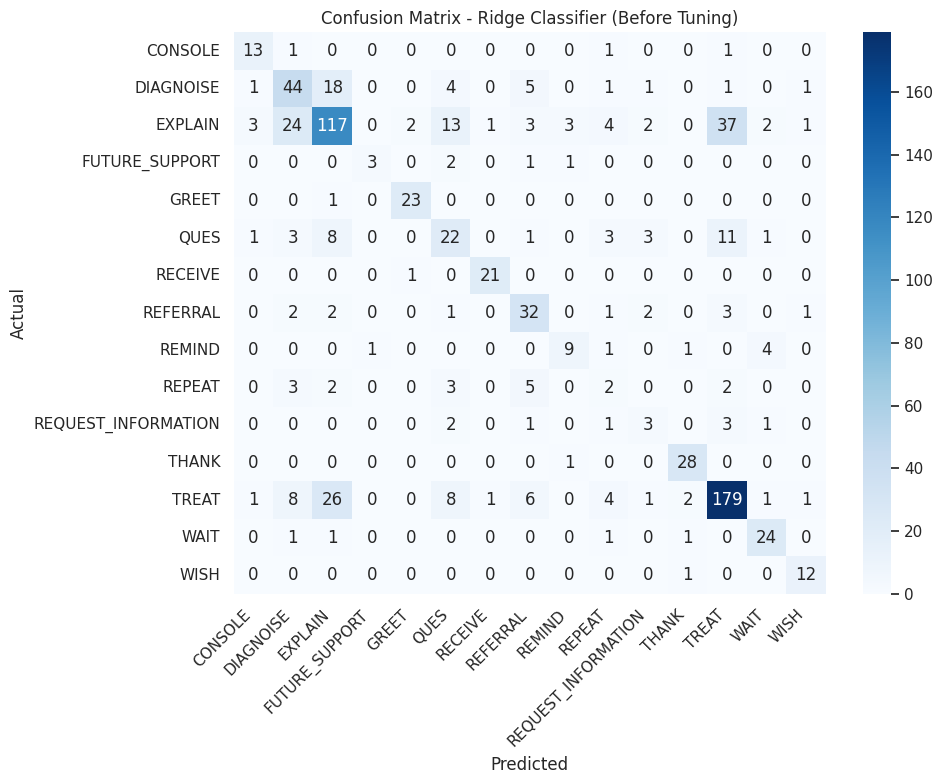


Ridge Classifier (After Tuning) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.68      0.81      0.74        16
          DIAGNOISE       0.52      0.51      0.52        76
            EXPLAIN       0.60      0.52      0.56       212
     FUTURE_SUPPORT       0.75      0.43      0.55         7
              GREET       0.85      0.96      0.90        24
               QUES       0.34      0.43      0.38        53
            RECEIVE       0.91      0.91      0.91        22
           REFERRAL       0.46      0.43      0.45        44
             REMIND       0.67      0.50      0.57        16
             REPEAT       0.14      0.12      0.13        17
REQUEST_INFORMATION       0.29      0.18      0.22        11
              THANK       0.79      0.93      0.86        29
              TREAT       0.70      0.75      0.72       238
               WAIT       0.72      0.75      0.74        28
               WISH       0.

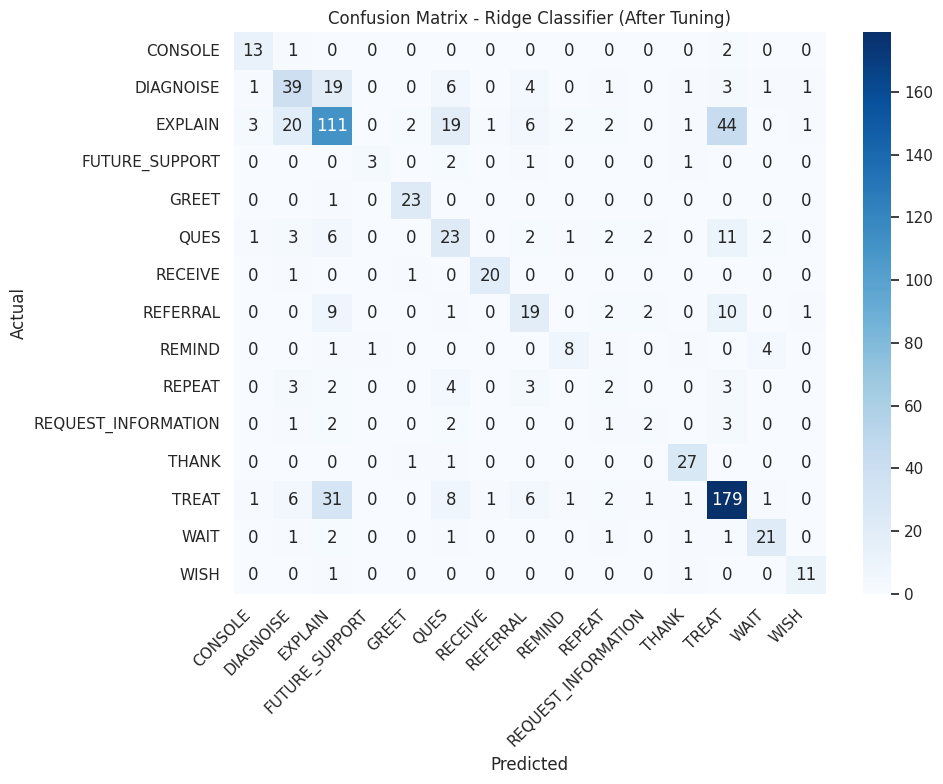


Ridge Classifier (Retrained Best) Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.68      0.81      0.74        16
          DIAGNOISE       0.52      0.51      0.52        76
            EXPLAIN       0.60      0.52      0.56       212
     FUTURE_SUPPORT       0.75      0.43      0.55         7
              GREET       0.85      0.96      0.90        24
               QUES       0.34      0.43      0.38        53
            RECEIVE       0.91      0.91      0.91        22
           REFERRAL       0.46      0.43      0.45        44
             REMIND       0.67      0.50      0.57        16
             REPEAT       0.14      0.12      0.13        17
REQUEST_INFORMATION       0.29      0.18      0.22        11
              THANK       0.79      0.93      0.86        29
              TREAT       0.70      0.75      0.72       238
               WAIT       0.72      0.75      0.74        28
               WISH       

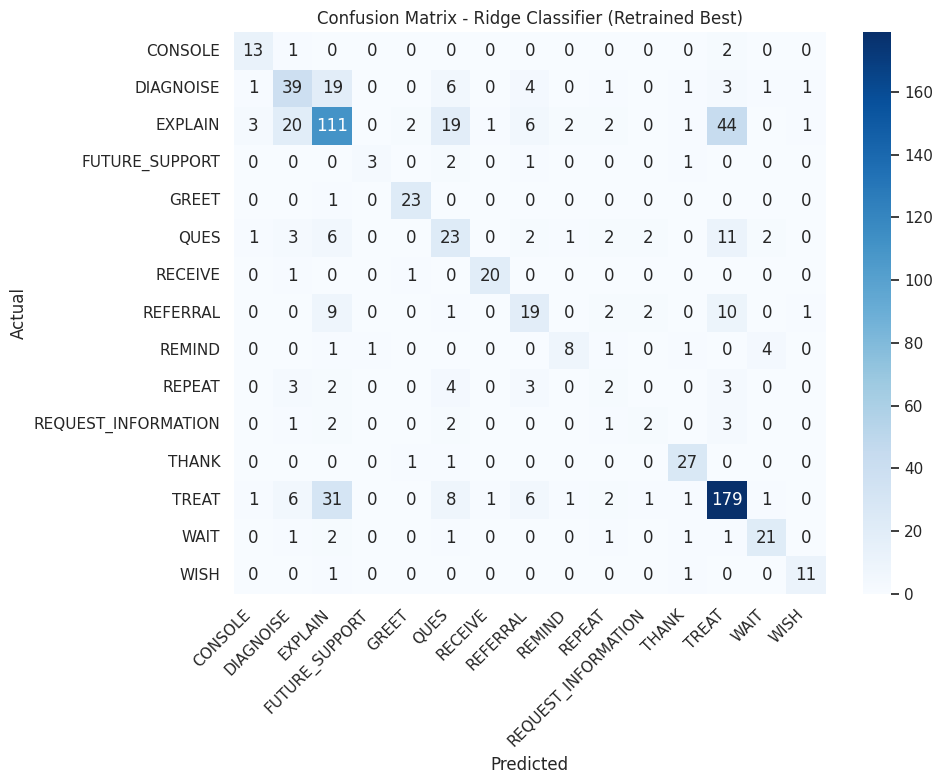

In [ ]:
print("\n===== Ridge Classifier =====")

# 1. Train Basic Ridge Classifier
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier()
ridge.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate on Validation Set (Before Tuning)
y_val_pred = ridge.predict(X_val_tfidf)
evaluate_model("Ridge Classifier (Before Tuning)", ridge, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred, labels=class_names, title="Confusion Matrix - Ridge Classifier (Before Tuning)")


# 2. Hyperparameter Tuning
grid = {"alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(RidgeClassifier(), param_grid=grid, cv=5, scoring='f1_weighted', n_jobs=-1)
ridge_cv.fit(X_train_tfidf_resample, y_train_resample)

# Evaluate Tuned Model (After Tuning)
y_val_pred_cv = ridge_cv.predict(X_val_tfidf)
evaluate_model("Ridge Classifier (After Tuning)", ridge_cv, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_cv, labels=class_names, title="Confusion Matrix - Ridge Classifier (After Tuning)")


# 3. Retrain with Best Hyperparameters
ridge_final = RidgeClassifier(alpha=ridge_cv.best_params_['alpha'])
ridge_final.fit(X_train_tfidf_resample, y_train_resample)

# Final Evaluation (Retrained Best)
y_val_pred_final = ridge_final.predict(X_val_tfidf)
evaluate_model("Ridge Classifier (Retrained Best)", ridge_final, X_val_tfidf, y_val)
plot_conf_matrix(y_val, y_val_pred_final, labels=class_names, title="Confusion Matrix - Ridge Classifier (Retrained Best)")


In [ ]:
# ------------------------------------------
# Evaluate Best Traditional Model (Logistic Regression) on Test Dataset
# ------------------------------------------

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Predict on Test Set using the retrained Logistic Regression model (log_reg_final)
y_test_pred = log_reg_final.predict(X_test_tfidf)

# Evaluate Performance
print("\n===== Evaluation on Test Set: Logistic Regression =====")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_test_true, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test_true, y_test_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test_true, y_test_pred, average='weighted'):.4f}")



===== Evaluation on Test Set: Logistic Regression =====
                     precision    recall  f1-score   support

            CONSOLE       0.75      0.67      0.71        27
          DIAGNOISE       0.51      0.56      0.54       119
            EXPLAIN       0.56      0.48      0.52       316
     FUTURE_SUPPORT       0.50      0.38      0.43         8
              GREET       0.96      0.93      0.95        29
               QUES       0.33      0.37      0.35       109
            RECEIVE       0.87      0.70      0.78        37
           REFERRAL       0.69      0.68      0.68        74
             REMIND       0.86      0.86      0.86        21
             REPEAT       0.33      0.13      0.19        30
REQUEST_INFORMATION       0.73      0.40      0.52        20
              THANK       0.86      1.00      0.92        43
              TREAT       0.68      0.81      0.74       281
               WAIT       0.92      0.87      0.89        52
               WISH       0

In [ ]:
# ------------------------------------------
# Universal Test Set Evaluation Function
# ------------------------------------------

def evaluate_on_test(model_name, model, X_test, y_test_true):
    y_test_pred = model.predict(X_test)
    print(f"\n===== Evaluation on Test Set: {model_name} =====")
    print(classification_report(y_test_true, y_test_pred, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test_true, y_test_pred))
    print(f"Test Accuracy: {accuracy_score(y_test_true, y_test_pred):.4f}")
    print(f"Test F1 Score: {f1_score(y_test_true, y_test_pred, average='weighted'):.4f}")


In [ ]:
# Evaluate all models on Test Set
evaluate_on_test("Logistic Regression", log_reg_final, X_test_tfidf, y_test_true)



===== Evaluation on Test Set: Logistic Regression =====
                     precision    recall  f1-score   support

            CONSOLE       0.75      0.67      0.71        27
          DIAGNOISE       0.51      0.56      0.54       119
            EXPLAIN       0.56      0.48      0.52       316
     FUTURE_SUPPORT       0.50      0.38      0.43         8
              GREET       0.96      0.93      0.95        29
               QUES       0.33      0.37      0.35       109
            RECEIVE       0.87      0.70      0.78        37
           REFERRAL       0.69      0.68      0.68        74
             REMIND       0.86      0.86      0.86        21
             REPEAT       0.33      0.13      0.19        30
REQUEST_INFORMATION       0.73      0.40      0.52        20
              THANK       0.86      1.00      0.92        43
              TREAT       0.68      0.81      0.74       281
               WAIT       0.92      0.87      0.89        52
               WISH       0

In [ ]:
evaluate_on_test("Support Vector Classifier", svc_final, X_test_tfidf, y_test_true)




===== Evaluation on Test Set: Support Vector Classifier =====
                     precision    recall  f1-score   support

            CONSOLE       0.89      0.59      0.71        27
          DIAGNOISE       0.57      0.24      0.33       119
            EXPLAIN       0.46      0.68      0.54       316
     FUTURE_SUPPORT       0.75      0.38      0.50         8
              GREET       0.93      0.93      0.93        29
               QUES       0.46      0.16      0.23       109
            RECEIVE       0.91      0.57      0.70        37
           REFERRAL       0.82      0.45      0.58        74
             REMIND       0.84      0.76      0.80        21
             REPEAT       0.00      0.00      0.00        30
REQUEST_INFORMATION       0.67      0.10      0.17        20
              THANK       0.95      0.98      0.97        43
              TREAT       0.61      0.84      0.71       281
               WAIT       0.91      0.75      0.82        52
               WISH  

In [ ]:
evaluate_on_test("K-Nearest Neighbors", knn_final, X_test_tfidf, y_test_true)



===== Evaluation on Test Set: K-Nearest Neighbors =====
                     precision    recall  f1-score   support

            CONSOLE       0.61      0.70      0.66        27
          DIAGNOISE       0.21      0.46      0.28       119
            EXPLAIN       0.43      0.02      0.04       316
     FUTURE_SUPPORT       0.43      0.38      0.40         8
              GREET       0.93      0.90      0.91        29
               QUES       0.13      0.65      0.22       109
            RECEIVE       0.83      0.65      0.73        37
           REFERRAL       0.50      0.16      0.24        74
             REMIND       0.73      0.76      0.74        21
             REPEAT       0.00      0.00      0.00        30
REQUEST_INFORMATION       0.42      0.25      0.31        20
              THANK       0.76      0.98      0.86        43
              TREAT       0.70      0.06      0.11       281
               WAIT       0.74      0.67      0.71        52
               WISH       0

In [ ]:
evaluate_on_test("Decision Tree", dt_final, X_test_tfidf, y_test_true)



===== Evaluation on Test Set: Decision Tree =====
                     precision    recall  f1-score   support

            CONSOLE       0.64      0.59      0.62        27
          DIAGNOISE       0.37      0.34      0.35       119
            EXPLAIN       0.46      0.31      0.37       316
     FUTURE_SUPPORT       0.75      0.38      0.50         8
              GREET       0.72      0.90      0.80        29
               QUES       0.24      0.41      0.30       109
            RECEIVE       0.82      0.62      0.71        37
           REFERRAL       0.56      0.45      0.50        74
             REMIND       0.47      0.67      0.55        21
             REPEAT       0.11      0.07      0.08        30
REQUEST_INFORMATION       0.60      0.60      0.60        20
              THANK       0.93      0.98      0.95        43
              TREAT       0.58      0.68      0.63       281
               WAIT       0.81      0.73      0.77        52
               WISH       0.68   

In [ ]:
evaluate_on_test("Random Forest", rf_final, X_test_tfidf, y_test_true)



===== Evaluation on Test Set: Random Forest =====
                     precision    recall  f1-score   support

            CONSOLE       0.70      0.59      0.64        27
          DIAGNOISE       0.49      0.41      0.45       119
            EXPLAIN       0.56      0.34      0.43       316
     FUTURE_SUPPORT       0.38      0.38      0.38         8
              GREET       0.90      0.93      0.92        29
               QUES       0.28      0.54      0.37       109
            RECEIVE       0.62      0.70      0.66        37
           REFERRAL       0.65      0.64      0.64        74
             REMIND       0.78      0.67      0.72        21
             REPEAT       0.50      0.03      0.06        30
REQUEST_INFORMATION       0.83      0.25      0.38        20
              THANK       0.88      0.98      0.92        43
              TREAT       0.63      0.79      0.70       281
               WAIT       0.81      0.83      0.82        52
               WISH       0.80   

In [ ]:
evaluate_on_test("Extra Trees", et_final, X_test_tfidf, y_test_true)



===== Evaluation on Test Set: Extra Trees =====
                     precision    recall  f1-score   support

            CONSOLE       0.70      0.59      0.64        27
          DIAGNOISE       0.49      0.45      0.47       119
            EXPLAIN       0.59      0.35      0.44       316
     FUTURE_SUPPORT       0.43      0.38      0.40         8
              GREET       0.96      0.93      0.95        29
               QUES       0.30      0.52      0.38       109
            RECEIVE       0.77      0.73      0.75        37
           REFERRAL       0.64      0.66      0.65        74
             REMIND       0.76      0.76      0.76        21
             REPEAT       0.60      0.10      0.17        30
REQUEST_INFORMATION       0.78      0.35      0.48        20
              THANK       0.86      1.00      0.92        43
              TREAT       0.64      0.81      0.71       281
               WAIT       0.80      0.87      0.83        52
               WISH       0.68     

In [ ]:
evaluate_on_test("Naive Bayes", nb, X_test_tfidf, y_test_true)   # Naive Bayes model has no tuning



===== Evaluation on Test Set: Naive Bayes =====
                     precision    recall  f1-score   support

            CONSOLE       0.55      0.81      0.66        27
          DIAGNOISE       0.48      0.48      0.48       119
            EXPLAIN       0.67      0.36      0.47       316
     FUTURE_SUPPORT       0.29      0.50      0.36         8
              GREET       0.82      0.93      0.87        29
               QUES       0.42      0.31      0.36       109
            RECEIVE       0.78      0.84      0.81        37
           REFERRAL       0.49      0.89      0.63        74
             REMIND       0.58      0.90      0.70        21
             REPEAT       0.15      0.30      0.20        30
REQUEST_INFORMATION       0.28      0.60      0.38        20
              THANK       0.95      0.93      0.94        43
              TREAT       0.70      0.69      0.70       281
               WAIT       0.73      0.90      0.81        52
               WISH       0.60     

In [ ]:
evaluate_on_test("Ridge Classifier", ridge_final, X_test_tfidf, y_test_true)


===== Evaluation on Test Set: Ridge Classifier =====
                     precision    recall  f1-score   support

            CONSOLE       0.68      0.70      0.69        27
          DIAGNOISE       0.43      0.42      0.43       119
            EXPLAIN       0.52      0.45      0.48       316
     FUTURE_SUPPORT       0.43      0.38      0.40         8
              GREET       0.93      0.97      0.95        29
               QUES       0.28      0.33      0.30       109
            RECEIVE       0.83      0.65      0.73        37
           REFERRAL       0.57      0.55      0.56        74
             REMIND       0.68      0.71      0.70        21
             REPEAT       0.19      0.10      0.13        30
REQUEST_INFORMATION       0.50      0.20      0.29        20
              THANK       0.91      0.95      0.93        43
              TREAT       0.62      0.74      0.67       281
               WAIT       0.72      0.83      0.77        52
               WISH       0.90

In [ ]:
evaluate_on_test("XGBoost", xgb_final, X_test_tfidf, y_test_true)


NameError: name 'xgb_final' is not defined